#  `gradient`


- Samples:
    - background sample : high $m(D^*3\pi)|m(D^*)=m(D^*)_{PDG})$ of `common` sample: `common` sample with $5400\ Mev/c^2 < m(D^*3\pi|m(D^*)=m(D^*)_{PDG}) < 5570\ MeV/c^2$, chosen in `notebooks/BDT/1_background_training.ipynb`
    - signal sample : `MC`
    
- For all the samples, `143. < Delta_M < 148.`
- Sample weight balancing (in `BDT.py`)
- Use `Gradient Boosting` classifier

What is done:
- Load the `MC` and `common` data
- Split them in two in some randomly, with some `random_state`
- Define the 2 background samples
- Plot the distributions of the variables for the signal and background sample (to compare the distributions and choose the one that are the most different for signal and background sample)
- Plot the correlation matrix
- Train the two BDTs (there is 2 background samples and 2 signal samples as we split these samples in 2)
- Plot the ROC curve and the overtraining check (with computation of the KS test to compare the BDT distributions for the training and test data)
- Apply the BDT 1 to the `common` data 2 and the BDT 2 to the `common` data 1
- Merge the two `BDT` outputs and `common` datasamples
- Plot some histograms to check that the BDT output is ok, in particular
    - 2D histograms of $(m(D^*3\pi|m(D^*)=m(D^*)_{PDG}), BDT)$ for the `common` and `MC` signal
    - BDT output
    - Distribution of $m(D^*3\pi|m(D^*)=m(D^*)_{PDG})$ when cutting on the $BDT$ variable
- Save the dataframe with all the variables and the BDT ouput.
- Save the MC BDT

In [7]:
name_BDT = 'gradient'
cstr_B0_M = 'Dst_constr_B0_M'

In [8]:
low_bkg = 5400.
high_bkg = 5570.

In [6]:
from bd2dst3pi.definitions import years, magnets
from bd2dst3pi.locations import loc
from copy import deepcopy
import pandas as pd
import numpy as np

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data, save_dataframe, save_json, get_real_vars, get_needed_vars, get_df_variables, add_constr_Dst
from plot.tool import save_file, set_text_LHCb, get_name_unit_particule_var
import plot.histogram as h
import BDT.BDT as bt


## Training variables

In [9]:
variables_functions = [
    ('B0_DIRA_OWNPV', 'ln(1-x)'),
    (('B0_ENDVERTEX_CHI2', 'B0_ENDVERTEX_NDOF'), 'x/y'),
    'B0_PT',
    ('B0_FDCHI2_OWNPV', 'ln(x)'),
    'B0_IP_OWNPV', # much better with it
#     'B0_FD_OWNPV',

    ('Dst_DIRA_OWNPV', 'ln(1-x)'), # better with it
    'Dst_PT',
#     'Dst_FDCHI2_OWNPV', # worse with it
    'Dst_IPCHI2_OWNPV',
    'Dst_IP_OWNPV',
#     'Dst_FD_OWNPV', # different for sWeighted and MC

#     ('D0_DIRA_OWNPV', 'ln(1-x)'), # worst with it # different for sWeighted and MC
#     (('D0_ENDVERTEX_CHI2', 'D0_ENDVERTEX_NDOF'), 'x/y'),
    'D0_PT',
    ('D0_FDCHI2_OWNPV', 'ln(x)'),
    ('D0_IPCHI2_OWNPV', 'ln(x)'),
    'D0_IP_OWNPV',
#     'D0_FD_OWNPV', # different for sWeighted and MC

#     ('tau_DIRA_OWNPV', 'ln(1-x)'), # different for sWeighted and MC
    (('tau_ENDVERTEX_CHI2', 'tau_ENDVERTEX_NDOF'), 'x/y'), # a bit worse without it 
    'tau_PT',
    ('tau_FDCHI2_OWNPV', 'ln(x)'),
    ('tau_IPCHI2_OWNPV', 'ln(x)'),
    'tau_IP_OWNPV',
#     'tau_FD_OWNPV', # better without it # different for sWeighted and MC

    'Dst_pion_PT',
    ('Dst_pion_IPCHI2_OWNPV', 'ln(x)'),

    'D0_kaon_PT',
    ('D0_kaon_IPCHI2_OWNPV', 'ln(x)'),

    'D0_pion_PT', # better with it
    ('D0_pion_IPCHI2_OWNPV', 'ln(x)'),
       
#     'B0_ETA', # different for sWeighted and MC
#     'Dst_ETA', # different for sWeighted and MC
#     'D0_ETA', # different for sWeighted and MC
#     'tau_ETA', # different for sWeighted and MC
#     'Dst_pion_ETA', # different for sWeighted and MC
#     'D0_kaon_ETA', # different for sWeighted and MC
#     'D0_pion_ETA', # different for sWeighted and MC
]

add_variables = ['B0_M', 'tau_M', 'Dst_M', 'D0_M']

In [10]:
len(variables_functions)

24

In [11]:
needed_variables = get_needed_vars(variables_functions)
variables = get_real_vars(variables_functions)

In [12]:
for v in variables:
    print(get_name_unit_particule_var(v)[0])

$ln(1-x)$ of the cosine of the DIRA angle($D^{*}3\pi$)
$\chi^2$ of the end vertex per d.o.f.($D^{*}3\pi$)
$p_T$($D^{*}3\pi$)
$ln(x)$ of the $\chi^2$ of the flight distance($D^{*}3\pi$)
Impact parameter($D^{*}3\pi$)
$ln(1-x)$ of the cosine of the DIRA angle($D^*$)
$p_T$($D^*$)
$\chi^2$ of the impact parameter($D^*$)
Impact parameter($D^*$)
$p_T$($D^0$)
$ln(x)$ of the $\chi^2$ of the flight distance($D^0$)
$ln(x)$ of the $\chi^2$ of the impact parameter($D^0$)
Impact parameter($D^0$)
$\chi^2$ of the end vertex per d.o.f.($3\pi$)
$p_T$($3\pi$)
$ln(x)$ of the $\chi^2$ of the flight distance($3\pi$)
$ln(x)$ of the $\chi^2$ of the impact parameter($3\pi$)
Impact parameter($3\pi$)
$p_T$($\pi$ from $D^*$)
$ln(x)$ of the $\chi^2$ of the impact parameter($\pi$ from $D^*$)
$p_T$($K$ from $D^0$)
$ln(x)$ of the $\chi^2$ of the impact parameter($K$ from $D^0$)
$p_T$($\pi$ of $D^0$)
$ln(x)$ of the $\chi^2$ of the impact parameter($\pi$ of $D^0$)


In [13]:
ind = "    "
for i, v in enumerate(variables):
    v_f = v.replace(':',' ').replace('/','d')
    if i%12==0:
        print('=================================================================')
    print(ind + "\\begin{minipage}[t]{0.32\\textwidth}")
    print(2*ind + "\\centering")
    print(2*ind + "\\includegraphics[width=6.1 cm]{BDT/variables/%s_MC_Background.pdf}"%v_f)
    print(ind + "\\end{minipage}")
    print(ind + "\\hfill%")
    

    \begin{minipage}[t]{0.32\textwidth}
        \centering
        \includegraphics[width=6.1 cm]{BDT/variables/B0_DIRA_OWNPV ln(1-x)_MC_Background.pdf}
    \end{minipage}
    \hfill%
    \begin{minipage}[t]{0.32\textwidth}
        \centering
        \includegraphics[width=6.1 cm]{BDT/variables/B0_ENDVERTEX_CHI2,B0_ENDVERTEX_NDOF xdy_MC_Background.pdf}
    \end{minipage}
    \hfill%
    \begin{minipage}[t]{0.32\textwidth}
        \centering
        \includegraphics[width=6.1 cm]{BDT/variables/B0_PT_MC_Background.pdf}
    \end{minipage}
    \hfill%
    \begin{minipage}[t]{0.32\textwidth}
        \centering
        \includegraphics[width=6.1 cm]{BDT/variables/B0_FDCHI2_OWNPV ln(x)_MC_Background.pdf}
    \end{minipage}
    \hfill%
    \begin{minipage}[t]{0.32\textwidth}
        \centering
        \includegraphics[width=6.1 cm]{BDT/variables/B0_IP_OWNPV_MC_Background.pdf}
    \end{minipage}
    \hfill%
    \begin{minipage}[t]{0.32\textwidth}
        \centering
        \includegraphics[widt

In [14]:
ind = "    "
for i, v in enumerate(variables):
    v_f = v.replace(':',' ').replace('/','d')
    if i%12==0:
        print('=================================================================')
    print(ind + "\\begin{minipage}[t]{0.32\\textwidth}")
    print(2*ind + "\\centering")
    print(2*ind + "\\includegraphics[width=6.1 cm]{BDT/variables_signal_vs_MC/%s_MC_Signal.pdf}"%v_f)
    print(ind + "\\end{minipage}")
    print(ind + "\\hfill%")

    \begin{minipage}[t]{0.32\textwidth}
        \centering
        \includegraphics[width=6.1 cm]{BDT/variables_signal_vs_MC/B0_DIRA_OWNPV ln(1-x)_MC_Signal.pdf}
    \end{minipage}
    \hfill%
    \begin{minipage}[t]{0.32\textwidth}
        \centering
        \includegraphics[width=6.1 cm]{BDT/variables_signal_vs_MC/B0_ENDVERTEX_CHI2,B0_ENDVERTEX_NDOF xdy_MC_Signal.pdf}
    \end{minipage}
    \hfill%
    \begin{minipage}[t]{0.32\textwidth}
        \centering
        \includegraphics[width=6.1 cm]{BDT/variables_signal_vs_MC/B0_PT_MC_Signal.pdf}
    \end{minipage}
    \hfill%
    \begin{minipage}[t]{0.32\textwidth}
        \centering
        \includegraphics[width=6.1 cm]{BDT/variables_signal_vs_MC/B0_FDCHI2_OWNPV ln(x)_MC_Signal.pdf}
    \end{minipage}
    \hfill%
    \begin{minipage}[t]{0.32\textwidth}
        \centering
        \includegraphics[width=6.1 cm]{BDT/variables_signal_vs_MC/B0_IP_OWNPV_MC_Signal.pdf}
    \end{minipage}
    \hfill%
    \begin{minipage}[t]{0.32\textwidth}
   

## Load data

### Full datasets

In [15]:
df = {}
print("retrieve MC")
df['MC'] = load_data(years,magnets, type_data = 'all_MC',vars = add_variables + needed_variables) # already cut on DeltaM
print("retrieve common data")
df['common'] = load_data(years, magnets, type_data = 'common', vars = add_variables + needed_variables, cut_DeltaM=True)

retrieve MC
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_up_Sim09c-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_down_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2015_down_Sim09c-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_up_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_up_Sim09c-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_down_Sim09e-ReDecay01.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//norm/Bd_Dst3pi/Bd_Dst3pi_11266018_2016_down_Sim09c-ReDecay01.r

In [16]:
df['common'] = get_df_variables(df['common'], variables_functions+add_variables)
df['MC'] = get_df_variables(df['MC'], variables_functions+add_variables)
df['common'] = add_constr_Dst(df['common'])
# df['MC'] = add_constr_Dst(df['common'])
add_variables += [cstr_B0_M]


#### Check NaN values

In [17]:
columns_common = list(df['common'].columns)
columns_MC = list(df['MC'].columns)

In [18]:
columns_common_noNaN = list(df['common'].dropna(axis='columns').columns)
columns_MC_noNaN = list(df['MC'].dropna(axis='columns').columns)

In [19]:
print("Columns of NaN values")
print("== common ==")
for c in columns_common:
    if c not in columns_common_noNaN:
        print(c)
        
print("== MC ==")
for c in columns_MC:
    if c not in columns_MC_noNaN:
        print(c)

Columns of NaN values
== common ==
== MC ==


In [20]:
list(df['common'].columns) == variables + add_variables

True

### Splitting of the `common` data

We randomly split the `common` data into two samples of same size

In [21]:
df['common1'] = df['common'].sample(frac=0.5, random_state=150)
df['common2'] = df['common'].drop(df['common1'].sort_index().index,0).sample(frac=1., random_state=150)

df['MC1'] = df['MC'].sample(frac=0.5, random_state=150).sort_index()
df['MC2'] = df['MC'].drop(df['MC1'].sort_index().index,0).sample(frac=1., random_state=150)

Some checks that they have the same size and are randomly separated

In [22]:
print(len(df['common1']), len(df['common2']))

255086 255087


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/Dst_constr_B0_M_data_1_data_2
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/Dst_constr_B0_M_data_1_data_2


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Proportion of candidates / (4 MeV/$c^2$)'>)

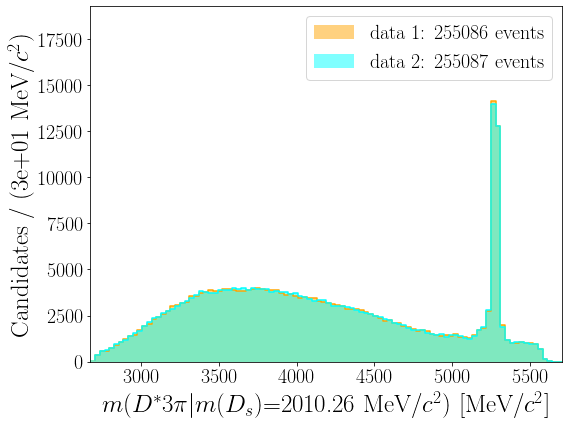

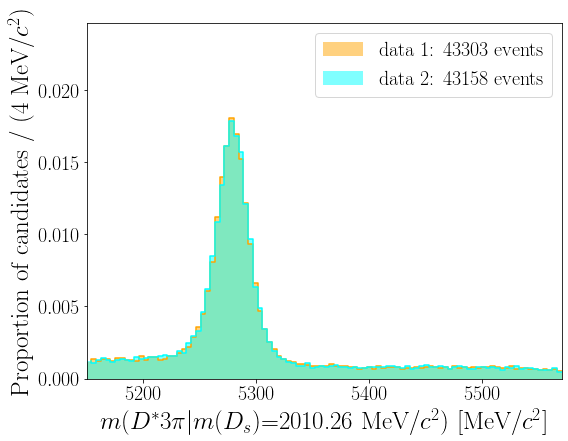

In [14]:
h.plot_hist_particle({'data 1': df['common1'], 'data 2':df['common2']}, cstr_B0_M,
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'], density=False)
low=5150
high=5570
h.plot_hist_particle({'data 1': df['common1'], 'data 2':df['common2']}, cstr_B0_M,
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'],
                    low=low, high=high)

### Background samples

#### Create the background samples

In [23]:
df['bkg1'] = df['common1'].query(f'{cstr_B0_M} > {low_bkg} and {cstr_B0_M} < {high_bkg}')
df['bkg2'] = df['common2'].query(f'{cstr_B0_M} > {low_bkg} and {cstr_B0_M} < {high_bkg}')
print('bgk1: ', len(df['bkg1']), 'events')
print('bgk2: ', len(df['bkg2']), 'events')

bgk1:  5479 events
bgk2:  5537 events


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/Dst_constr_B0_M_bkg_1_bkg_2


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (2 MeV/$c^2$)'>)

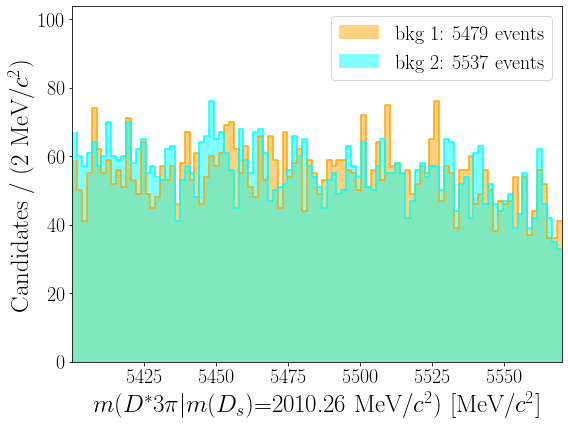

In [16]:
h.plot_hist_particle({'bkg 1': df['bkg1'], 'bkg 2':df['bkg2']},cstr_B0_M,
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'], density=False)

#### Remove unwanted variables (keep only the training variables)

In [24]:
for data in 'common1', 'common2', 'bkg1', 'bkg2', 'MC1', 'MC2': # with training variables
    df[data+'_t'] = deepcopy(df[data])
    for add_var in add_variables+['index']:
        try:
            df[data+'_t'] = df[data+'_t'].drop(add_var, 1)
        except KeyError:
            pass

#### Create the samples that will be used for the training-test, with a new variable `y`
- = 1 if signal
- = 0 if backgrond

In [25]:
X = {}
y = {}

In [26]:
for i in '1', '2':
    X[i], y[i], df[f'train_test{i}'] = bt.concatenate(df[f'MC{i}_t'], df[f'bkg{i}_t'])


#### Create the training and test sample

In [27]:
Xt = {'train': {}, 'test': {}}
yt = {'train': {}, 'test': {}}

In [28]:
for i in '1', '2':
    Xt['train'][i], Xt['test'][i], yt['train'][i], yt['test'][i] = bt.get_train_test(X[i], y[i])

#### Separate the `y` variable from the other variables

In [29]:
assert len(Xt['test']['1'].T) == len(variables)
assert len(Xt['test']['2'].T) == len(variables)
assert len(Xt['train']['1'].T) == len(variables)
assert len(Xt['train']['2'].T) == len(variables)

assert len(Xt['test']['1'])==len(yt['test']['1'])
assert len(Xt['test']['2'])==len(yt['test']['2'])
assert len(Xt['train']['1'])==len(yt['train']['1'])
assert len(Xt['train']['2'])==len(yt['train']['2'])

#### Create the training and test sample

## Training

In [30]:
bdt1 = bt.BDT(Xt['train']['1'], yt['train']['1'], classifier = 'gradientboosting', n_estimators=400, 
              learning_rate=0.1)

hyperparameters:
n_estimators: 400
learning_rate: 0.1
      Iter       Train Loss   Remaining Time 
         1           1.2734           19.11s
         2           1.1810           18.86s
         3           1.1039           18.71s
         4           1.0374           18.64s
         5           0.9810           18.55s
         6           0.9321           18.50s
         7           0.8900           18.47s
         8           0.8531           18.42s
         9           0.8203           18.35s
        10           0.7928           18.28s
        20           0.6158           17.82s
        30           0.5276           17.30s
        40           0.4760           16.78s
        50           0.4435           16.27s
        60           0.4189           15.79s
        70           0.4017           15.30s
        80           0.3885           14.83s
        90           0.3783           14.37s
       100           0.3694           13.90s
       200           0.3282            9.24s


In [31]:
bdt2 = bt.BDT(Xt['train']['2'], yt['train']['2'], classifier='gradientboosting', n_estimators=400, 
              learning_rate=0.1)

hyperparameters:
n_estimators: 400
learning_rate: 0.1
      Iter       Train Loss   Remaining Time 
         1           1.2777           22.20s
         2           1.1865           20.42s
         3           1.1100           19.78s
         4           1.0445           19.43s
         5           0.9875           19.21s
         6           0.9389           19.05s
         7           0.8970           18.92s
         8           0.8606           18.82s
         9           0.8276           18.74s
        10           0.7995           18.63s
        20           0.6310           17.86s
        30           0.5433           17.29s
        40           0.4917           16.79s
        50           0.4564           16.32s
        60           0.4312           15.84s
        70           0.4125           15.35s
        80           0.3988           14.87s
        90           0.3874           14.40s
       100           0.3783           13.94s
       200           0.3343            9.28s


## Testing

### Report

In [25]:
# bt.classification_report_print(X_test1, y_test1, bdt1,name_BDT+'1')
# bt.classification_report_print(X_test2, y_test2, bdt2,name_BDT+'2')
bt.classification_report_print(Xt['test']['1'], yt['test']['1'], bdt1,name_BDT+'1')
bt.classification_report_print(Xt['test']['2'], yt['test']['2'], bdt2,name_BDT+'2')

              precision    recall  f1-score   support

  background       0.85      0.91      0.88      2782
      signal       0.98      0.96      0.97     11148

    accuracy                           0.95     13930
   macro avg       0.91      0.93      0.92     13930
weighted avg       0.95      0.95      0.95     13930

Area under ROC curve: 0.9814
              precision    recall  f1-score   support

  background       0.85      0.92      0.88      2808
      signal       0.98      0.96      0.97     11151

    accuracy                           0.95     13959
   macro avg       0.92      0.94      0.93     13959
weighted avg       0.95      0.95      0.95     13959

Area under ROC curve: 0.9813


### Roc curve

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient1/ROC_gradient1
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient2/ROC_gradient2


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='False Positive Rate', ylabel='True Positive Rate'>)

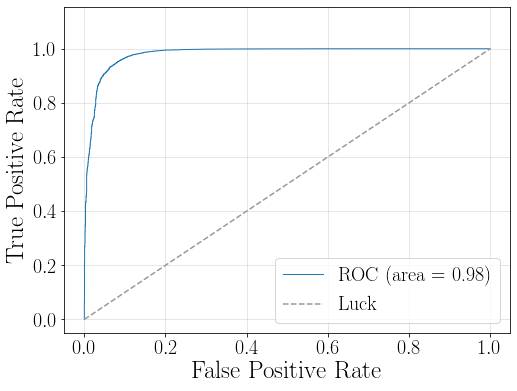

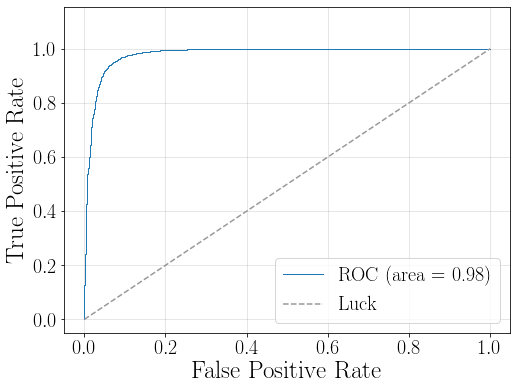

In [26]:
# bt.plot_roc(X_test1, y_test1, bdt1, name_BDT+'1', name_folder = name_BDT+'1')
# bt.plot_roc(X_test2, y_test2, bdt2, name_BDT+'2', name_folder = name_BDT+'2')
bt.plot_roc(Xt['test']['1'], yt['test']['1'], bdt1, name_BDT+'1', name_folder = name_BDT+'1')
bt.plot_roc(Xt['test']['2'], yt['test']['2'], bdt2, name_BDT+'2', name_folder = name_BDT+'2')

### Overtraining check

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient1/overtraining_gradient1
Kolmogorov-Smirnov statistic
signal    : 0.021964522713017926
Background: 0.012506799334870311
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient2/overtraining_gradient2
Kolmogorov-Smirnov statistic
signal    : 0.012324495056264935
Background: 0.00786916554609024


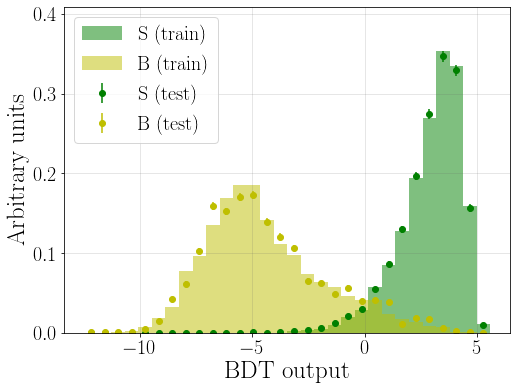

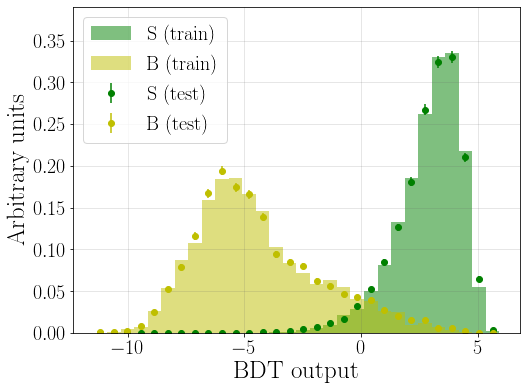

In [32]:
# _,_,ks_2samp_sig1,ks_2samp_bkg1 = bt.compare_train_test(bdt1, X_train1, y_train1, X_test1, y_test1, name_BDT = name_BDT+'1', name_folder = name_BDT+'1')
# _,_,ks_2samp_sig2,ks_2samp_bkg2 = bt.compare_train_test(bdt2, X_train2, y_train2, X_test2, y_test2, name_BDT = name_BDT+'2', name_folder = name_BDT+'2')


_,_,ks_2samp_sig1,ks_2samp_bkg1 = bt.compare_train_test(bdt1, Xt['train']['1'], yt['train']['1'], 
                                                        Xt['test']['1'], yt['test']['1'], 
                                                        name_BDT = name_BDT+'1', name_folder = name_BDT+'1',
                                                       colors=['g', 'y'])
_,_,ks_2samp_sig2,ks_2samp_bkg2 = bt.compare_train_test(bdt2, Xt['train']['2'], yt['train']['2'], 
                                                        Xt['test']['2'], yt['test']['2'], 
                                                        colors=['g', 'y'],
                                                        name_BDT = name_BDT+'2', name_folder = name_BDT+'2')

In [28]:
save_json({'sig1':ks_2samp_sig1,'bkg1':ks_2samp_bkg1, 'sig2':ks_2samp_sig2, 'bkg2':ks_2samp_bkg2}, name_data='ks_2samp', name_folder=name_BDT)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/gradient/ks_2samp_params.json


### Save the BDT output for the MC

In [50]:
low = 5150.
high = 5570.

In [51]:
BDT2 = bdt1.decision_function(df['MC2_t'])
BDT1 = bdt2.decision_function(df['MC1_t'])

In [52]:
df_MC_test = pd.DataFrame()
df_MC_test['BDT'] = np.concatenate([BDT1,BDT2])

In [53]:
df['MC1']['BDT'] = BDT1
df['MC2']['BDT'] = BDT2

df['MC_concat'] = pd.concat([df['MC1'],df['MC2']])
df['MC_concat'] = add_constr_Dst(df['MC_concat'])

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient/BDTvsB0_M_MC


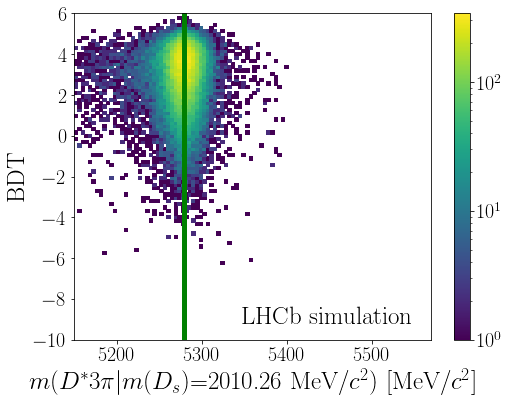

In [54]:
fig, ax = h.plot_hist2d_particle(df['MC_concat'],[cstr_B0_M,'BDT'], low=[low,-10],high=[high,6.],
            name_folder = name_BDT, log_scale = True, save_fig=False, 
                                 pos_text_LHC={'x':0.95, 'y':0.1, 'ha':'right', 'text':'LHCb simulation'})
ax.axvline(x=5279.53, color='green', linewidth=5.)
save_file(fig, "BDTvsB0_M_MC", name_BDT)

In [42]:
for var in variables:
    try:
        df['MC_concat'] = df['MC_concat'].drop(var, 1)
    except KeyError:
        pass

In [43]:
df['MC_concat'].columns

Index(['B0_M', 'tau_M', 'Dst_M', 'D0_M', 'BDT', 'Dst_constr_B0_M'], dtype='object')

In [44]:
save_dataframe(df['MC_concat'], f'MC_{name_BDT}', 'DecayTree', name_folder = 'MC')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/MC/MC_gradient.root


### Apply to the data

In [45]:
df['common1']['BDT'] = bdt2.decision_function(df['common1_t'])
df['common2']['BDT'] = bdt1.decision_function(df['common2_t'])

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data_1_data_2


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Proportion of candidates / (0.2)'>)

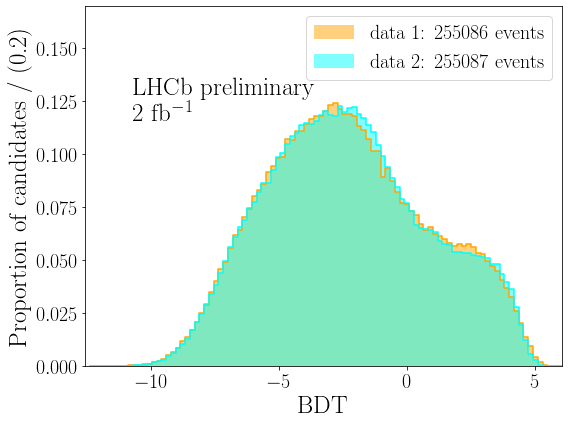

In [46]:
h.plot_hist_particle({'data 1': df['common1'], 'data 2':df['common2']}, 'BDT',
              n_bins = 100, mode_hist = True, colors=['orange', 'cyan'], pos_text_LHC=[0.1,0.8,'left'])

In [47]:
df['common_withBDT'] = pd.concat([df['common1'],df['common2']])
len(df['common_withBDT']) == len(df['common1']) + len(df['common2'])

True

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Candidates / (0.2)'>)

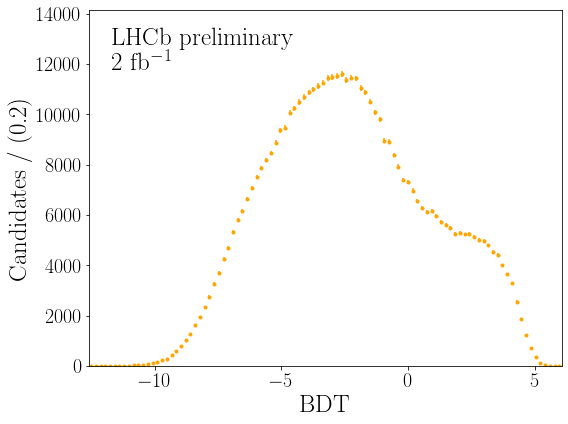

In [48]:
h.plot_hist_particle({'data': df['common_withBDT']},'BDT',
              n_bins = 100, mode_hist = False, colors=['orange', 'cyan'], pos_text_LHC=[0.05,0.95,'left'])

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient/BDT_cut_B0_M


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

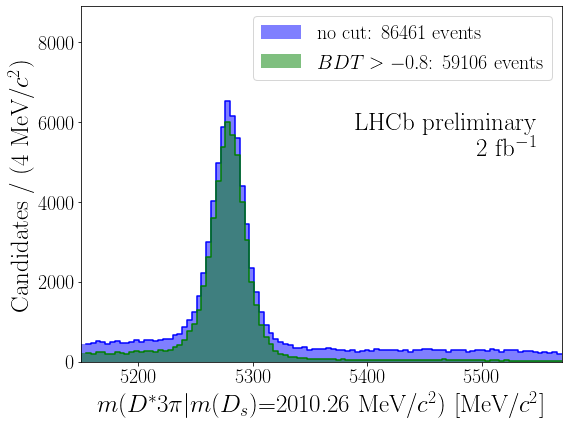

In [49]:
h.plot_hist_particle({'no cut':df['common_withBDT'], '$BDT>-0.8$':df['common_withBDT'].query('BDT>-0.8')},
          cstr_B0_M, n_bins = 100,low = low,high=high,mode_hist=True, 
                       colors=['b', 'g', 'r'], pos_text_LHC=[0.95, 0.70, 'right'],
            name_file = 'BDT_cut_B0_M',name_folder = name_BDT, density=False)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient/BDT_cut_on_B0_M


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

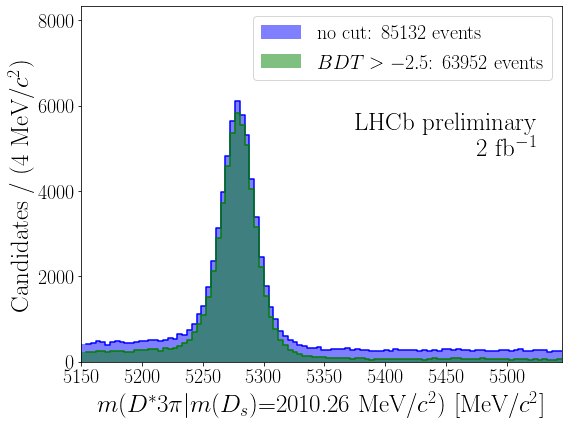

In [53]:
h.plot_hist_particle({'no cut':df['common_withBDT'], '$BDT>-2.5$':df['common_withBDT'].query('BDT>-2.5')},
          cstr_B0_M, n_bins = 100,low = low,high=5545,mode_hist=True, 
                       colors=['b', 'g', 'r'], pos_text_LHC=[0.95, 0.70, 'right'],
            name_file = 'BDT_cut_on_B0_M',name_folder = name_BDT, density=False)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient/BDTvsB0_M


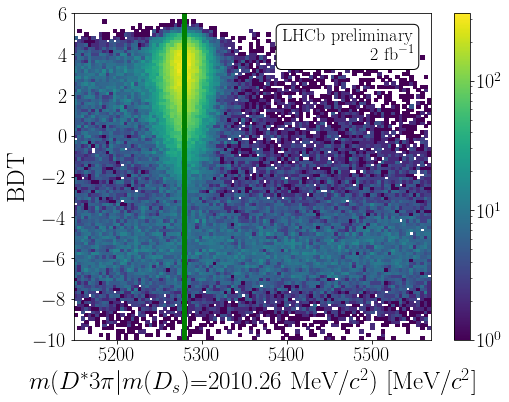

In [56]:
fig, ax = h.plot_hist2d_particle(df['common_withBDT'],[cstr_B0_M,'BDT'], low=[low,-10],high=[high,6.],
            name_folder = name_BDT, log_scale = True, save_fig=False)
ax.axvline(x=5279.53, color='green', linewidth=5.)
t = set_text_LHCb(ax, pos=[0.95, 0.95, 'right'], fontsize=18)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black', boxstyle='round'))
save_file(fig, "BDTvsB0_M",name_BDT)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/gradient/background_BDT_cut_B0_M


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

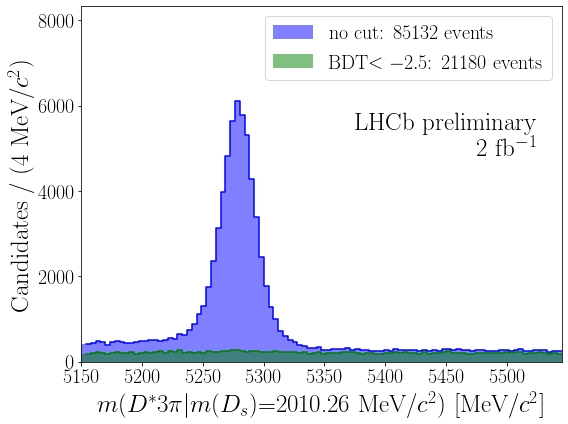

In [55]:
h.plot_hist_particle({'no cut':df['common_withBDT'], 'BDT$<-2.5$':df['common_withBDT'].query('BDT<-2.5')},
          cstr_B0_M, n_bins = 100,low = low, high=5545,mode_hist=True, 
                       colors=['b', 'g', 'r'], pos_text_LHC=[0.95, 0.70, 'right'],
            name_file = 'background_BDT_cut_B0_M',name_folder = name_BDT, density=False)

In [494]:
for var in variables:
    try:
        df['common_withBDT'] = df['common_withBDT'].drop(var, 1)
    except KeyError:
        pass

In [495]:
save_dataframe(df['common_withBDT'], f'common_{name_BDT}', 'DecayTree', name_folder = 'common')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_gradient.root
